# Data Processing

# Models
Below we will have 4 different models which will help us predict wins and loses of nba games

### Logistic Regression Model
Run this model using data from 2012-2024 without using rolling averages then we incorporate a 10 day rolling average to predict wins/loses

In [2]:
# Created by Gio Romero-Ruiz
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np


# Loads the dataset
df = pd.read_csv('../data/season-data/2012_to_2024_data.csv')

# Convert 'date' column to datetime format and create a new 'season' column based on the month
df['date_temp'] = pd.to_datetime(df['date'])
df['season'] = df['date_temp'].apply(lambda x: x.year + 1 if x.month >= 10 else x.year)

# Removes the temporary 'date-temp' column
df.drop(columns=['date_temp'], inplace=True)

# sorts the dataframe by date
df = df.sort_values('date')


# Remove columns related to minutes played
del df['mp']
del df['mp_opp']

# add in target column to predict how team did in their next game
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team


# Apply the function to each team separately
df = df.groupby('team', group_keys=False).apply(add_target)

df['target'][pd.isnull(df['target'])] = 2
# find columns with null values
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]

# remove columns with null values
valid_columns = df.columns[~df.columns.isin(nulls.index)]
df = df[valid_columns].copy()

# model time 
lr = LogisticRegression(random_state= 0, max_iter=2000)

# prepare a time-series cross-validator
split = TimeSeriesSplit(n_splits=3)

# initialize sequential feature selector for feature selection
sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward', cv=split)


# this line below specifies the columns to remove before feature selection
removed_columns = ['team', 'date', 'won', 'target', 'team_opp', 'season']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])

# performs the feature selection below
sfs.fit(df[selected_columns], df['target'])
predictors = list(selected_columns[sfs.get_support()])


# Function to backtest the model using historical data
def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    # Extract a sorted list of unique seasons from the data to determine the temporal boundaries for training and testing.
    seasons = sorted(data['season'].unique())

    # Iterate over the seasons, starting from the specified start index and moving in steps defined by 'step'.
    for i in range(start, len(seasons), step):

        # Separate the data into training and testing sets:
        # Training data includes all data from seasons prior to the current season in the iteration.
        # Testing data includes all data from the current season.
        train = data[data['season'] < seasons[i]]
        test = data[data['season'] == seasons[i]]
        
        # Fit the model to the training data using the specified predictors and the target variable.
        model.fit(train[predictors], train['target'])

        # Predict the target variable for the testing data using the fitted model.
        predictions = model.predict(test[predictors])
        predictions = pd.Series(predictions, index=test.index)

        # Combine the actual target values and the predictions into a DataFrame for comparison.
        combined = pd.concat([test['target'], predictions], axis=1)
        combined.columns = ['actual', 'prediction']

        # Append the results of this season's predictions to the list of all predictions.
        all_predictions.append(combined)
    
    # Concatenate all prediction DataFrames into a single DataFrame to return the combined results.
    return pd.concat(all_predictions)

# Execute the backtest and compute the accuracy
# This is all before rolling 10 day rolling averages.
predictions = backtest(df, lr, predictors)
accruacy_lr = accuracy_score(predictions['actual'], predictions['prediction'])
print(accruacy_lr)

C:\Users\giova\AppData\Local\Temp\ipykernel_28908\1605032853.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('team', group_keys=False).apply(add_target)
C:\Users\giova\AppData\Local\Temp\ipykernel_28908\1605032853.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column 

0.5353892027620841


In [3]:
### Incorporating the 10 day rolling averages

# We created a new dataframe which includes selected features along with 'won', 'team' and 'season' columns
df_rolling = df[list(selected_columns) + ['won', 'team', 'season']]

# We defined a function here to calculate rolling averages for each team's numneric data
def find_team_averages(team):
    # Select only numeric columns for rolling calculation
    numeric_cols = team.select_dtypes(include=[np.number])  # Using numpy to select numeric columns
    rolling = numeric_cols.rolling(10).mean()
    return rolling


# Apply the function to each group defined by 'team' and 'season' to maintain unique groups
# group_keys=False prevents adding an extra index level of the grouping keys
df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)


# Generate new column names for the rolling average columns
# This is done by appending '_rolling' to each original column name
# For example, if the original column name is 'points', the new name will be 'points_rolling'
rolling_cols = [f'{col}_rolling' for col in df_rolling.columns]
df_rolling.columns = rolling_cols


# Will concatenate the original DataFrame(df) with the rolling averages DataFrame(df_rolling)
df = pd.concat([df, df_rolling], axis=1)


# Remove rows with missing values from the DataFrame
df= df.dropna()

# Create a copy of the DataFrame to ensure that the original data is not modified by reference elsewhere in the code
df = df.copy()

# This function is designed to help retrieve the next value of a column for each entry within the same team.
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

# This function is particularly useful for creating new columns that anticipate future events or states, like the next opponent.
def add_col(team, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))

# Add a new column 'team_opp_next' to the DataFrame which contains the next opponent for each team.
df["team_opp_next"] = add_col(df, "team_opp")

# This column is also created using the add_col function with 'date' as the column to shift.
df["date_next"] = add_col(df, "date")



# Create a copy of the DataFrame to ensure that subsequent operations do not modify the original DataFrame by reference.
df = df.copy()


# Merge the DataFrame with a subset of itself that includes only the rolling average columns and key columns for matching.
# The purpose of this merge is to align data from one row in 'df' with data from another row where the first row's 'team' and 'date_next'
# match the second row's 'team_opp_next' and 'date_next'. This aligns teams with their next opponents based on the date of the next game.
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])



# Select and display specific columns from the 'full' DataFrame to examine particular relationships and data alignments.
full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]


# Identify and list all columns in the 'full' DataFrame that have data type 'object', typically indicating categorical or textual data.
# This step is useful for preprocessing data, especially before applying machine learning algorithms that require numerical input.
removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns


# Create a list of columns that are not in the 'removed_columns' list.
# This involves filtering the 'full' DataFrame's columns by excluding those identified as needing removal.
selected_columns = full.columns[~full.columns.isin(removed_columns)]

# Apply the Sequential Feature Selector (SFS) to the 'full' DataFrame using the filtered 'selected_columns'.
# The 'target' column is used as the dependent variable in the model fitting process.
# SFS is a feature selection method that iteratively adds (or removes) features to find the set of features that best improves the performance of the model.
# It fits the Logistic Regression model specified earlier in the workflow to the selected features to identify the most informative ones.
sfs.fit(full[selected_columns], full['target'])


# Retrieve the names of the columns that the Sequential Feature Selector (SFS) identified as the most predictive.
predictors = list(selected_columns[sfs.get_support()])


# Call the backtest function with the DataFrame 'full', a Logistic Regression model 'lr', and the list of selected predictor columns.
# The function 'backtest' is designed to train and test the model on different subsets of the data defined by 'season' or similar splits,
# simulating a real-world application where models are trained on past data and tested on future, unseen data.
predictions = backtest(full, lr, predictors)

# Calculate the accuracy score, which is the proportion of correct predictions out of all predictions made.
accuracy_lr_rolling = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_lr_rolling)

C:\Users\giova\AppData\Local\Temp\ipykernel_28908\2497240628.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
C:\Users\giova\AppData\Local\Temp\ipykernel_28908\2497240628.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
C:

0.6132721091438915


### XG-Boost Model

In [4]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np


# Loads the dataset
df = pd.read_csv('../data/season-data/2012_to_2024_data.csv')

# Convert 'date' column to datetime format and create a new 'season' column based on the month
df['date_temp'] = pd.to_datetime(df['date'])
df['season'] = df['date_temp'].apply(lambda x: x.year + 1 if x.month >= 10 else x.year)

#Removes the temporary 'date-temp' column
df.drop(columns=['date_temp'], inplace=True)

# sorts the dataframe by date
df = df.sort_values('date')


# Remove columns related to minutes played
del df['mp']
del df['mp_opp']

# add in target column to predict how team did in their next game
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

# Apply the function to each team separately
df = df.groupby('team', group_keys=False).apply(add_target)


df['target'] = df['target'].fillna(0).astype(int)
# Ensure the target has only 0 and 1
df['target'] = df['target'].apply(lambda x: 1 if x == 1 else 0)

# find columns with null values
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]

# remove columns with null values
valid_columns = df.columns[~df.columns.isin(nulls.index)]

df = df[valid_columns].copy()

# model time 
xgboost = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)

# prepare a time-series cross-validator
split = TimeSeriesSplit(n_splits=3)

# initialize sequential feature selector for feature selection
sfs = SequentialFeatureSelector(xgboost, n_features_to_select=10, direction='forward', cv=split)

# this line below specifies the columns to remove before feature selectionz
removed_columns = ['team', 'date', 'won', 'target', 'team_opp', 'season']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])

# performs the feature selection below
sfs.fit(df[selected_columns], df['target'])
predictors = list(selected_columns[sfs.get_support()])


# Function to backtest the model using historical data
def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    # Extract a sorted list of unique seasons from the data to determine the temporal boundaries for training and testing.
    seasons = sorted(data['season'].unique())
    
    
    # Iterate over the seasons, starting from the specified start index and moving in steps defined by 'step'.
    for i in range(start, len(seasons), step):

        # Separate the data into training and testing sets:
        # Training data includes all data from seasons prior to the current season in the iteration.
        # Testing data includes all data from the current season.
        train = data[data['season'] < seasons[i]]
        test = data[data['season'] == seasons[i]]
        
        # Fit the model to the training data using the specified predictors and the target variable.
        model.fit(train[predictors], train['target'])

        # Predict the target variable for the testing data using the fitted model.
        predictions = model.predict(test[predictors])
        predictions = pd.Series(predictions, index=test.index)

        # Combine the actual target values and the predictions into a DataFrame for comparison.
        combined = pd.concat([test['target'], predictions], axis=1)
        combined.columns = ['actual', 'prediction']

        # Append the results of this season's predictions to the list of all predictions.
        all_predictions.append(combined)
        
    # Concatenate all prediction DataFrames into a single DataFrame to return the combined results.
    return pd.concat(all_predictions)

# Execute the backtest and compute the accuracy
# This is all before rolling 10 day rolling averages.
predictions = backtest(df, xgboost, predictors)
accuracy_xgboost = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_xgboost)

C:\Users\giova\AppData\Local\Temp\ipykernel_28908\2285855508.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('team', group_keys=False).apply(add_target)


0.5338983050847458


In [5]:
# Implement the 10 day rolling average

# We created a new dataframe which includes selected features along with 'won', 'team' and 'season' columns
df_rolling = df[list(selected_columns) + ['won', 'team', 'season']]


# We defined a function here to calculate rolling averages for each team's numneric data
def find_team_averages(team):
    # Select only numeric columns for rolling calculation
    numeric_cols = team.select_dtypes(include=[np.number])  # Using numpy to select numeric columns
    rolling = numeric_cols.rolling(10).mean()
    return rolling


# Apply the function to each group defined by 'team' and 'season' to maintain unique groups
# group_keys=False prevents adding an extra index level of the grouping keys
df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)


# Generate new column names for the rolling average columns
# This is done by appending '_rolling' to each original column name
# For example, if the original column name is 'points', the new name will be 'points_rolling'
rolling_cols = [f'{col}_rolling' for col in df_rolling.columns]

# Apply the new column names to the df_rolling DataFrame
df_rolling.columns = rolling_cols

# Will concatenate the original DataFrame(df) with the rolling averages DataFrame(df_rolling)
df = pd.concat([df, df_rolling], axis=1)


# Remove rows with missing values from the DataFrame
df= df.dropna()

# Create a copy of the DataFrame to ensure that the original data is not modified by reference elsewhere in the code
df = df.copy()


# This function is designed to help retrieve the next value of a column for each entry within the same team.
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

# This function is particularly useful for creating new columns that anticipate future events or states, like the next opponent.
def add_col(team, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))

# Add a new column 'team_opp_next' to the DataFrame which contains the next opponent for each team.
df["team_opp_next"] = add_col(df, "team_opp")

# This column is also created using the add_col function with 'date' as the column to shift.
df["date_next"] = add_col(df, "date")



# Create a copy of the DataFrame to ensure that subsequent operations do not modify the original DataFrame by reference.
df = df.copy()


# Merge the DataFrame with a subset of itself that includes only the rolling average columns and key columns for matching.
# The purpose of this merge is to align data from one row in 'df' with data from another row where the first row's 'team' and 'date_next'
# match the second row's 'team_opp_next' and 'date_next'. This aligns teams with their next opponents based on the date of the next game
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])


# Select and display specific columns from the 'full' DataFrame to examine particular relationships and data alignments.
full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]

# Identify and list all columns in the 'full' DataFrame that have data type 'object', typically indicating categorical or textual data.
# This step is useful for preprocessing data, especially before applying machine learning algorithms that require numerical input.
removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns

# Create a list of columns that are not in the 'removed_columns' list.
# This involves filtering the 'full' DataFrame's columns by excluding those identified as needing removal.
selected_columns = full.columns[~full.columns.isin(removed_columns)]


# Apply the Sequential Feature Selector (SFS) to the 'full' DataFrame using the filtered 'selected_columns'.
# The 'target' column is used as the dependent variable in the model fitting process.
# SFS is a feature selection method that iteratively adds (or removes) features to find the set of features that best improves the performance of the model.
# It fits the Logistic Regression model specified earlier in the workflow to the selected features to identify the most informative ones.
sfs.fit(full[selected_columns], full['target'])


# Call the backtest function with the DataFrame 'full', a XGBoost model 'xgboost', and the list of selected predictor columns.
# The function 'backtest' is designed to train and test the model on different subsets of the data defined by 'season' or similar splits,
# simulating a real-world application where models are trained on past data and tested on future, unseen data.
predictions = backtest(full, xgboost, predictors)

# Calculate the accuracy score, which is the proportion of correct predictions out of all predictions made.
accuracy_xgboost_rolling = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_xgboost_rolling)

C:\Users\giova\AppData\Local\Temp\ipykernel_28908\3618422774.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
C:\Users\giova\AppData\Local\Temp\ipykernel_28908\3618422774.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
C:

0.5349905073071659


### Ridge Regression Model

In [6]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np

df = pd.read_csv('../data/season-data/2012_to_2023_data.csv')

# Convert date column to datetime type
df['date_temp'] = pd.to_datetime(df['date'])

# Add a season column based on the date
df['season'] = df['date_temp'].apply(lambda x: x.year + 1 if x.month >= 10 else x.year)
df.drop(columns=['date_temp'], inplace=True)
df = df.sort_values('date')
df

# delete unnecessary columns
del df['mp']
del df['mp_opp']
df

# add in target column to predict how team did in their next game
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team


# Apply the function to each team separately
df = df.groupby('team', group_keys=False).apply(add_target)
df[df['team'] == 'NYK'].sort_values('date')

df['target'][pd.isnull(df['target'])] = 2
df['target'].value_counts()
# find columns with null values
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]


# remove columns with null values
valid_columns = df.columns[~df.columns.isin(nulls.index)]
valid_columns

# Filter the DataFrame 'df' to include only the columns listed in 'valid_columns', 
df = df[valid_columns].copy()


# Initialize a Ridge Classifier model. The alpha parameter controls the strength of regularization.
# In Ridge regression, increasing alpha forces coefficients to move more toward zero, which decreases training set performance but can help generalize better for new data.
rr = RidgeClassifier(alpha=1.0)

# Setup a TimeSeriesSplit object for cross-validation, specifying 3 splits.
split = TimeSeriesSplit(n_splits=3)

# Initialize Sequential Feature Selector with the Ridge Classifier, specifying to select 10 features.
sfs = SequentialFeatureSelector(rr, n_features_to_select=10, direction='forward', cv=split)

# this line below specifies the columns to remove before feature selectionz
removed_columns = ['team', 'date', 'won', 'target', 'team_opp', 'season']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
# scale columns to be between 0 and 1 so that the model can be trained and perform better
df[selected_columns] = scaler.fit_transform(df[selected_columns])


# performs the feature selection below
sfs.fit(df[selected_columns], df['target'])

# get the best 10 predictors that will be used for our RR model
predictors = list(selected_columns[sfs.get_support()])

# Function to backtest the model using historical data
def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    # Extract a sorted list of unique seasons from the data to determine the temporal boundaries for training and testing.
    seasons = sorted(data['season'].unique())

    # Iterate over the seasons, starting from the specified start index and moving in steps defined by 'step'.
    for i in range(start, len(seasons), step):

        # Separate the data into training and testing sets:
        # Training data includes all data from seasons prior to the current season in the iteration.
        # Testing data includes all data from the current season.
        train = data[data['season'] < seasons[i]]
        test = data[data['season'] == seasons[i]]


        # Fit the model to the training data using the specified predictors and the target variable.
        model.fit(train[predictors], train['target'])

        # Predict the target variable for the testing data using the fitted model.
        predictions = model.predict(test[predictors])
        predictions = pd.Series(predictions, index=test.index)

        # Combine the actual target values and the predictions into a DataFrame for comparison.
        combined = pd.concat([test['target'], predictions], axis=1)
        combined.columns = ['actual', 'prediction']
        
        # Append the results of this season's predictions to the list of all predictions.
        all_predictions.append(combined)
        
    # Concatenate all prediction DataFrames into a single DataFrame to return the combined results.
    return pd.concat(all_predictions)

# display the accuracy
accuracy_rr = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_rr)

C:\Users\giova\AppData\Local\Temp\ipykernel_28908\2581725170.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('team', group_keys=False).apply(add_target)
C:\Users\giova\AppData\Local\Temp\ipykernel_28908\2581725170.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column 

0.5349905073071659


In [7]:
## Rolling averages code
# We created a new dataframe which includes selected features along with 'won', 'team' and 'season' columns
df_rolling = df[list(selected_columns) + ['won', 'team', 'season']]


# We defined a function here to calculate rolling averages for each team's numneric data
def find_team_averages(team):
    # Select only numeric columns for rolling calculation
    numeric_cols = team.select_dtypes(include=[np.number])  # Using numpy to select numeric columns
    numeric_cols = numeric_cols.drop(columns=['season'])
    rolling = numeric_cols.rolling(10).mean()
    return rolling

# Apply the function to each group defined by 'team' and 'season' to maintain unique groups
# group_keys=False prevents adding an extra index level of the grouping keys
df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)



# Generate new column names for the rolling average columns
# This is done by appending '_rolling' to each original column name
# For example, if the original column name is 'points', the new name will be 'points_rolling'
rolling_cols = [f'{col}_rolling' for col in df_rolling.columns]

# Apply the new column names to the df_rolling DataFrame
df_rolling.columns = rolling_cols

# Will concatenate the original DataFrame(df) with the rolling averages DataFrame(df_rolling)
df = pd.concat([df, df_rolling], axis=1)


# Remove rows with missing values from the DataFrame
df= df.dropna()

# Create a copy of the DataFrame to ensure that the original data is not modified by reference elsewhere in the code
df = df.copy()


# This function is designed to help retrieve the next value of a column for each entry within the same team.
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

# This function is particularly useful for creating new columns that anticipate future events or states, like the next opponent.
def add_col(team, col_name):
    return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))

# Add a new column 'team_opp_next' to the DataFrame which contains the next opponent for each team.
df["team_opp_next"] = add_col(df, "team_opp")

# This column is also created using the add_col function with 'date' as the column to shift.
df["date_next"] = add_col(df, "date")

# Create a copy of the DataFrame to ensure that subsequent operations do not modify the original DataFrame by reference.
df = df.copy()

# Merge the DataFrame with a subset of itself that includes only the rolling average columns and key columns for matching.
# The purpose of this merge is to align data from one row in 'df' with data from another row where the first row's 'team' and 'date_next'
# match the second row's 'team_opp_next' and 'date_next'. This aligns teams with their next opponents based on the date of the next game
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])


# Select and display specific columns from the 'full' DataFrame to examine particular relationships and data alignments.
full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]

# Identify and list all columns in the 'full' DataFrame that have data type 'object', typically indicating categorical or textual data.
# This step is useful for preprocessing data, especially before applying machine learning algorithms that require numerical input.
removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns

# Create a list of columns that are not in the 'removed_columns' list.
# This involves filtering the 'full' DataFrame's columns by excluding those identified as needing removal.
selected_columns = full.columns[~full.columns.isin(removed_columns)]

# Apply the Sequential Feature Selector (SFS) to the 'full' DataFrame using the filtered 'selected_columns'.
# The 'target' column is used as the dependent variable in the model fitting process.
# SFS is a feature selection method that iteratively adds (or removes) features to find the set of features that best improves the performance of the model.
# It fits the Logistic Regression model specified earlier in the workflow to the selected features to identify the most informative ones.
sfs.fit(full[selected_columns], full['target'])

# Retrieve the names of the columns that the Sequential Feature Selector (SFS) identified as the most predictive.
predictors = list(selected_columns[sfs.get_support()])

# Call the backtest function with the DataFrame 'full', a Ridge Regression model 'rr', and the list of selected predictor columns.
# The function 'backtest' is designed to train and test the model on different subsets of the data defined by 'season' or similar splits,
# simulating a real-world application where models are trained on past data and tested on future, unseen data.
predictions = backtest(full, rr, predictors)

# Calculate the accuracy score, which is the proportion of correct predictions out of all predictions made.
accuracy_rr_rolling = accuracy_score(predictions['actual'], predictions['prediction'])
print(accuracy_rr_rolling)

C:\Users\giova\AppData\Local\Temp\ipykernel_28908\838024650.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling = df_rolling.groupby(['team', 'season'], group_keys=False).apply(find_team_averages)
C:\Users\giova\AppData\Local\Temp\ipykernel_28908\838024650.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
C:\U

0.6177404386264836


### Neural Network

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


# Select features and target
X = full[selected_columns]
y = full['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model configuration
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='leaky_relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='leaky_relu'),
    tf.keras.layers.Dense(4, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='SGD',
              loss='MSE',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
loss, accuracy_nn = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy_nn:.2f}")

c:\Users\giova\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,153 (16.22 KB)

 Trainable params: 4,153 (16.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5214 - loss: 0.2779 - val_accuracy: 0.5724 - val_loss: 0.2451
Epoch 2/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5764 - loss: 0.2441 - val_accuracy: 0.5876 - val_loss: 0.2390
Epoch 3/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.5937 - loss: 0.2386 - val_accuracy: 0.5995 - val_loss: 0.2367
Epoch 4/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.5970 - loss: 0.2366 - val_accuracy: 0.6025 - val_loss: 0.2354
Epoch 5/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.5953 - loss: 0.2349 - val_accuracy: 0.6065 - val_loss: 0.2346
Epoch 6/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6047 - loss: 0.2340 - val_accuracy: 0.6072 - val_loss: 0.2338
Epoch 7/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6105 - loss: 0.2322 - val_accuracy: 0.6112 - val_loss: 0.2333
Epoch 8/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.6064 - loss: 0.2328 - val_ac

### Plots
First we are going to plot the models accuracies without rolling averages

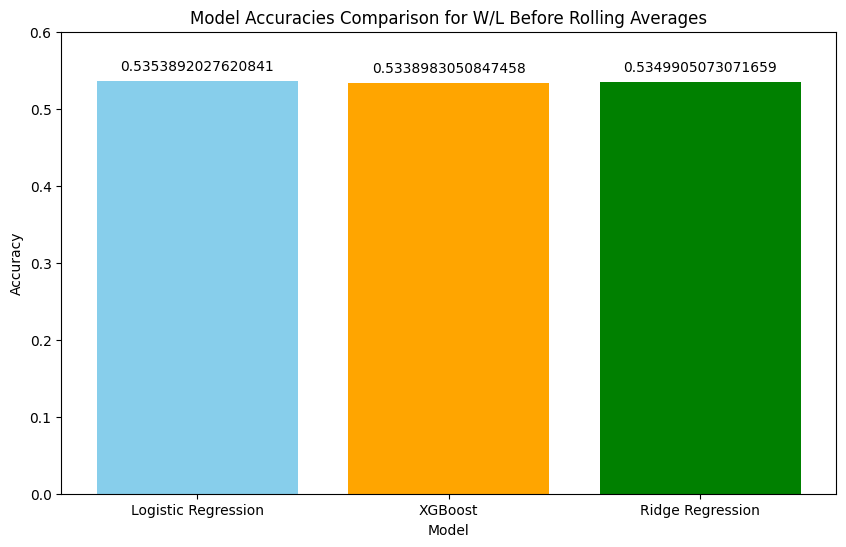

In [9]:
import matplotlib.pyplot as plt

# create a dictionary of accuracies to later plot them
model_accuracies = {
    'Logistic Regression': accruacy_lr,
    'XGBoost': accuracy_xgboost,
    'Ridge Regression': accuracy_rr,
}

# gather the model names and the accuracy names
model_names = list(model_accuracies.keys())
accuracy_values = list(model_accuracies.values())

colors = ['skyblue', 'orange', 'green']
# Create a bar graph with matplotlib

# Set the figure size
plt.figure(figsize=(10, 6))

# Set bar color
bars = plt.bar(model_names, accuracy_values, color=colors)

# Title for the plot
plt.title('Model Accuracies Comparison for W/L Before Rolling Averages')

# Label for the x-axis
plt.xlabel('Model')

# Label for the y-axis
plt.ylabel('Accuracy') 

# Set y-axis limits to represent accuracy as a percentage
plt.ylim(0, .6)

# Add text labels for the actual accuracy values on top of each bar without rounding
for bar in bars:
    yval = bar.get_height()  # Get the height (accuracy) of the bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Position text at the center of the bar, slightly above it
             yval,  # Use the exact float value for accuracy
             ha='center', va='bottom')  # Horizontal alignment to center, vertical alignment to bottom

# Display the plot
plt.show() 

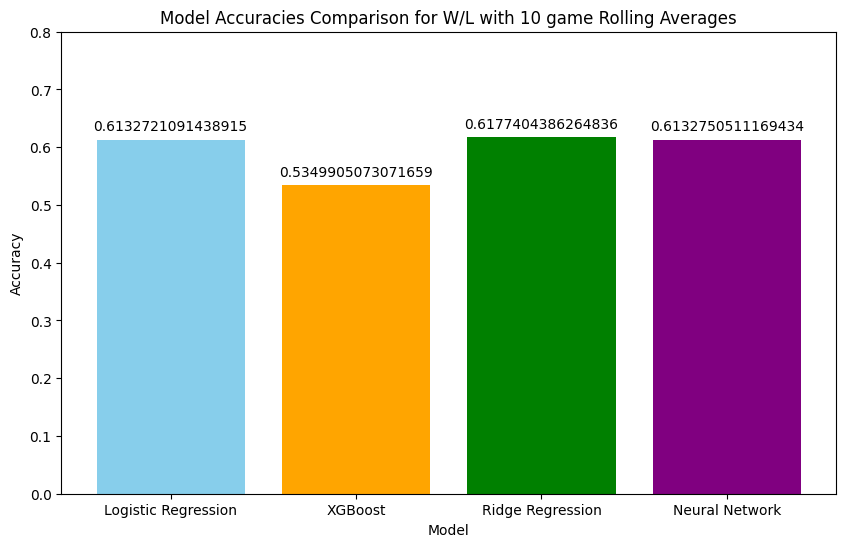

In [10]:
import matplotlib.pyplot as plt

# create a dictionary of accuracies to later plot them
model_accuracies = {
    'Logistic Regression': accuracy_lr_rolling,
    'XGBoost': accuracy_xgboost_rolling,
    'Ridge Regression': accuracy_rr_rolling,
    'Neural Network': accuracy_nn,
}


# gather the model names and the accuracy names
model_names = list(model_accuracies.keys())
accuracy_values = list(model_accuracies.values())

colors = ['skyblue', 'orange', 'green', 'purple']
# Create a bar graph with matplotlib
# Set the figure size
plt.figure(figsize=(10, 6)) 

# Set bar color
bars = plt.bar(model_names, accuracy_values, color=colors)

# Title for the plot
plt.title('Model Accuracies Comparison for W/L with 10 game Rolling Averages')

# Label for the x-axis
plt.xlabel('Model') 

# Label for the y-axis
plt.ylabel('Accuracy') 

# Set y-axis limits to represent accuracy as a percentage
plt.ylim(0, .8)

# Add text labels for the actual accuracy values on top of each bar without rounding
for bar in bars:
    yval = bar.get_height()  # Get the height (accuracy) of the bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Position text at the center of the bar, slightly above it
             yval,  # Use the exact float value for accuracy
             ha='center', va='bottom')  # Horizontal alignment to center, vertical alignment to bottom

# Display the plot
plt.show()